<a href="https://colab.research.google.com/github/singhsukhendra/2015/blob/master/GAN_for_Pneumonia_Detection_27_dec_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FPN on Covid Chest XRay to detect opacity


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# ensure consistency across runs
from numpy.random import seed
seed(1)

# Imports to view data
import cv2
from glob import glob

#for alternative imports you can use 
#from keras.preprocessing.image import ImageDataGenerator
#from keras.models import Sequential
#from keras.layers import Conv2D, SeparableConv2D, Dense, Dropout, Flatten, LSTM,MaxPool2D, BatchNormalization
#from keras import backend
#from keras import Input
#from keras.models import Model
#from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping


from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, Dense, Dropout, Flatten, LSTM,MaxPool2D, BatchNormalization
from tensorflow.keras import backend
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [2]:
! cp /content/drive/MyDrive/FPN/kaggle.json   /content/

In [ ]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

100% 1.14G/1.14G [00:12<00:00, 86.0MB/s]
100% 1.14G/1.14G [00:12<00:00, 94.9MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("/content/pneumonia-xray-images.zip","r") as zip_ref:
    zip_ref.extractall("chest-xray-pneumonia")

In [ ]:
# Loading the data
train_data_dir = "/content/chest-xray-pneumonia/train"
val_data_dir = "/content/chest-xray-pneumonia/val"
test_data_dir = "/content/chest-xray-pneumonia/test"

target_size = (128,128)   
target_dims = (128, 128, 3) # add channel for RGB
n_batch_size = 32 

In [ ]:
data_augmentor = ImageDataGenerator(samplewise_center=True, rescale=1./255, shear_range=0.2,zoom_range = 0.2,samplewise_std_normalization=True)

train_generator = data_augmentor.flow_from_directory(train_data_dir,  target_size=target_size, subset='training',batch_size= n_batch_size,class_mode='binary')
val_generator = data_augmentor.flow_from_directory(val_data_dir, target_size=target_size,subset='validation',class_mode='binary')
test_generator = data_augmentor.flow_from_directory(test_data_dir, target_size=target_size,batch_size= 1,class_mode=None, shuffle=False)

# 
train_generator.class_indices

Found 4192 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


{'normal': 0, 'opacity': 1}

In [ ]:
data_augmentor = ImageDataGenerator(samplewise_center=True, rescale=1./255, shear_range=0.2,zoom_range = 0.2,samplewise_std_normalization=True,validation_split=0.2) 

train_generator = data_augmentor.flow_from_directory(train_data_dir,  target_size=target_size, subset='training',batch_size= n_batch_size,class_mode='binary')
val_generator = data_augmentor.flow_from_directory(train_data_dir, target_size=target_size,subset='validation',class_mode='binary')
test_generator = data_augmentor.flow_from_directory(test_data_dir, target_size=target_size,batch_size= 1,class_mode=None, shuffle=False)


Found 3354 images belonging to 2 classes.
Found 838 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
input_path = '/content/chest-xray-pneumonia/'

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/normal/', '/opacity/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/normal/':
                label = 0
            elif cond=='/opacity/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
# Hyperparameters
img_dims = 150
epochs = 30
batch_size = 32

# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Input layer
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [ ]:
# Fitting the model
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/30
131/131 [==============================] - 88s 584ms/step - loss: 0.3948 - accuracy: 0.8146 - val_loss: 0.6608 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 2/30
131/131 [==============================] - 78s 596ms/step - loss: 0.2766 - accuracy: 0.8786 - val_loss: 0.6809 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 3/30
131/131 [==============================] - 78s 598ms/step - loss: 0.2432 - accuracy: 0.8998 - val_loss: 1.1437 - val_accuracy: 0.6201 - lr: 0.0010
Epoch 4/30
131/131 [==============================] - 78s 597ms/step - loss: 0.2284 - accuracy: 0.9086 - val_loss: 0.5983 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 5/30
131/131 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.9249
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 76s 581ms/step - loss: 0.2031 - accuracy: 0.9249 - val_loss: 0.9987 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 6/30
131/131 [=========================

In [ ]:
model.save('/content/GAN_on_Pneumonia.h5')

In [ ]:
model.save_weights('/content/GAN_weights_Covid.hdf5')

In [ ]:
from tensorflow.keras.models import  load_model

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

In [ ]:
prediction=preds[0:100]



In [ ]:
print('CONFUSION MATRIX')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100

print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRICs ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX
[[187  47]
 [  7 383]]

TEST METRICS ----------------------
Accuracy: 91.34615384615384%
Precision: 89.06976744186046%
Recall: 98.2051282051282%
F1-score: 93.41463414634146

TRAIN METRICs ----------------------
Train acc: 94.99


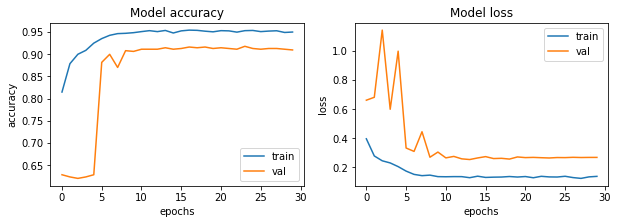

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Add code to display confusion matrix and ROC curve


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

GAN on Covid detection


In [ ]:
!pip uninstall tensorflow
!pip uninstall keras
!pip install tensorflow==2.2
!pip install keras==2.3.0

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.7.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
y
  Successfully uninstalled tensorflow-2.7.0
Found existing installation: keras 2.7.0
Uninstalling keras-2.7.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/keras-2.7.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/keras/*
Proceed (y/n)? y
  Successfully uninstalled keras-2.7.0
     |████████████████████████████████| 516.2 MB 4.2 kB/s 
     |████████████████████████████████| 2.9 MB 45.6 MB/s 
     |████████████████████████████████| 3.0 MB 35.8 MB/s 
   

     |████████████████████████████████| 377 kB 5.4 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 


In [ ]:
#Install essential libraries

!pip install zipfile36
!pip install git+https://github.com/mr7495/RetinaNet

  Cloning https://github.com/mr7495/RetinaNet to /tmp/pip-req-build-prfm9xip
  Running command git clone -q https://github.com/mr7495/RetinaNet /tmp/pip-req-build-prfm9xip
  Running command git submodule update --init --recursive -q
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp37-cp37m-linux_x86_64.whl size=181957 sha256=082bf81a633a4343976544fcb80c75b7ed5959d39450c2b77809b18877256b96
  Stored in directory: /tmp/pip-ephem-wheel-cache-z4yu_o26/wheels/8e/b1/07/21d38dc193334c5223fad2a1fb909d2621ce0e1c69d1a648e4
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13344 sha256=0de76fb3fca95d6b98fcdbc8fc9f0fe54e5d71bdab0312b3021cbdaf8401da3e
  Stored in directory: /root/.cache/pip/wheels/a6/20/57/d7b7be8556e2ebf36345b3df4068a9a13bb90e4a2cc85a6994
Successfully built keras-retinanet keras-resnet


In [ ]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy



import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv
import zipfile
import keras
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet101V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception



from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
import keras.backend as k
from sklearn.utils import shuffle
import io
from PIL import Image as pil_image
from keras_retinanet import layers
import keras.backend as k
import keras_retinanet

Using TensorFlow backend.


In [ ]:
shape=(299,299,1)
train_datagen = ImageDataGenerator(validation_split = 0.1)



train_gen = train_datagen.flow_from_directory("/content/chest-xray-pneumonia/train" ,
                                              target_size = shape[:2],
                                              batch_size = 32 ,
                                              class_mode = 'categorical',
                                              shuffle = True ,
                                              subset = 'training',
                                              seed = 42)

val_gen = train_datagen.flow_from_directory("/content/chest-xray-pneumonia/val" ,
                                              target_size = shape[:2],
                                              batch_size = 32 ,
                                              class_mode = 'categorical',
                                              shuffle = True ,
                                              subset = 'validation',
                                              seed = 42)

Found 3773 images belonging to 2 classes.
Found 103 images belonging to 2 classes.


In [ ]:
m=InceptionV3(weights = "imagenet", include_top=False)
m.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
______________________

In [ ]:
#from tensorflow import keras

In [ ]:
fold_num=1
k.clear_session() #Clear keras backend 
try:
  os.mkdir('models') #create folder for saving the trained networks
except:
  pass
full_name='InceptionV3-FPN-fold{}'.format(fold_num)
classes_number=2 #Number of classes (normal and COVID-19)
input_tensor=Input(shape=(299,299,3))
weight_model = InceptionV3(weights='imagenet', include_top=False) #Load ResNet50V2 ImageNet pre-trained weights
weight_model.save_weights('weights.h5') #Save the weights
base_model = InceptionV3(weights=None, include_top=False, input_tensor=input_tensor) #Load the ResNet50V2 model without weights
base_model.load_weights('weights.h5',skip_mismatch=True, by_name=True) #Load the ImageNet weights on the ResNet50V2 model except the first layer(because the first layer has one channel in our case)

#Create Feature Pyramid Network (FPN)
# We used some help for writing the Pyramid from the written code on https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/models/retinanet.py
feature_size=256 #Set the feature channels of the FPN
layer_names = ["mixed7", "mixed8", "mixed9"] #Layers of ResNet50V2 with different scale features 
layer_outputs = [base_model.get_layer(name).output for name in layer_names]
C3, C4, C5=layer_outputs #Features of different scales, extracted from ResNet50V2
P5           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C5_reduced')(C5)
P5_upsampled = layers.UpsampleLike(name='P5_upsampled')([P5, C4])
P5           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P5')(P5)

# Concatenate P5 elementwise to C4
P4           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C4_reduced')(C4)
P4           = keras.layers.Concatenate(axis=3)([P5_upsampled, P4])
P4_upsampled = layers.UpsampleLike(name='P4_upsampled')([P4, C3])
P4           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P4')(P4)

# Concatenate P4 elementwise to C3
P3 = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C3_reduced')(C3)
P3 = keras.layers.Concatenate(axis=3)([P4_upsampled, P3])
P3 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P3')(P3)

# "P6 is obtained via a 3x3 stride-2 conv on C5"
P6 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P6')(C5)

# "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
P7 = keras.layers.Activation('relu', name='C6_relu')(P6)
P7 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P7')(P7)

# Run classification for each of the generated features from the pyramid
feature1 = Flatten()(P3)
dp1 = Dropout(0.5)(feature1)
preds1 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp1)
#################################################################
feature2 = Flatten()(P4)
dp2 = Dropout(0.5)(feature2)
preds2 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp2)
#################################################################
feature3 = Flatten()(P5)
dp3= Dropout(0.5)(feature3)
preds3 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp3)
#################################################################
feature4 = Flatten()(P6)
dp4 = Dropout(0.5)(feature4)
preds4 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp4)
#################################################################
feature5 = Flatten()(P7)
dp5 = Dropout(0.5)(feature5)
preds5 = Dense(2, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp5)
#################################################################
concat=keras.layers.Concatenate(axis=1)([preds1,preds2,preds3,preds4,preds5]) #Concatenate the predictions(Classification results) of each of the pyramid features 
out=keras.layers.Dense(2,activation='softmax',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(concat) #Final Classification

model = Model(inputs=base_model.input, outputs=out) #Create the Training Model
#######################################################
for layer in model.layers:
  layer.trainable = True
model.compile(optimizer=keras.optimizers.Nadam(lr=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
filepath="models/%s-{epoch:02d}-{accuracy:.4f}.hdf5"%full_name  # Path to save the trained models
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]

history=model.fit_generator(train_gen, epochs=10,shuffle=True,callbacks=callbacks_list,validation_data=val_gen) #start training#,validation_data=val_gen

Epoch 1/10
118/118 [==============================] - 232s 2s/step - loss: 0.2193 - accuracy: 0.9128 - val_loss: 1.0161 - val_accuracy: 0.7476
Epoch 2/10
118/118 [==============================] - 186s 2s/step - loss: 0.0906 - accuracy: 0.9671 - val_loss: 0.7780 - val_accuracy: 0.7476
Epoch 3/10
118/118 [==============================] - 186s 2s/step - loss: 0.0642 - accuracy: 0.9775 - val_loss: 4.5119 - val_accuracy: 0.8447
Epoch 4/10
118/118 [==============================] - 187s 2s/step - loss: 0.0403 - accuracy: 0.9873 - val_loss: 0.1559 - val_accuracy: 0.9806
Epoch 5/10
118/118 [==============================] - 186s 2s/step - loss: 0.0361 - accuracy: 0.9873 - val_loss: 0.0010 - val_accuracy: 0.8544
Epoch 6/10
118/118 [==============================] - 186s 2s/step - loss: 0.0290 - accuracy: 0.9891 - val_loss: 0.0099 - val_accuracy: 0.9320
Epoch 7/10
118/118 [==============================] - 186s 2s/step - loss: 0.0273 - accuracy: 0.9886 - val_loss: 0.0173 - val_accuracy: 0.9029

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [ ]:
model.save('/content/FPN_on_Pneumonia.h5')

In [ ]:
model.save_weights('/content/FPN_on_Pneumonia.hdf5')

In [ ]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


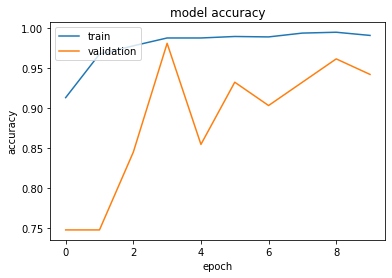

In [ ]:
# tensorboard logs 
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


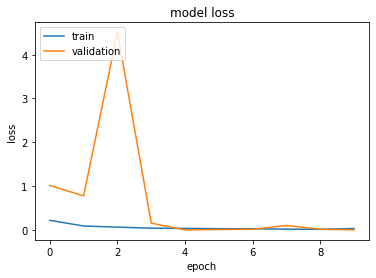

In [ ]:

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Add code to display confusion matrix and ROC curve 

Apply Attention Network for Opacity detection on above dataset with accuracy,Confusion matrix, ROC Curve, AUC 